<a href="https://colab.research.google.com/github/qkrwoghd04/ImageCaptionnng_Using_ViT/blob/master/practice/Vision_Transformer_Architecture_Practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### ViT Architecture Practice

Distinguishing between a person **sleeping** and a person **falling down**


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install --upgrade keras

In [ ]:
!pip install ops

## Initialization

In [82]:
import numpy as np
import tensorflow as tf
import keras
from keras import layers
import keras as keras
from keras import ops

#hyperparameter
input_shape = (32,32,3)
batch_size = 64
epochs = 20
lr = 3e-5
gamma = 0.7
seed = 142
image_size = 128
patch_size = 16
num_classes = 2

In [83]:
import os
from tensorflow.keras.preprocessing.image import img_to_array, load_img
# 이미지와 레이블을 저장할 리스트 초기화
x_train = []
y_train = []

# 클래스별로 폴더 경로 설정
classes = ['Fall', 'Sleep']
class_labels = {'Fall': 0, 'Sleep': 1}

base_path = '/content/drive/MyDrive/image_dataset/processed'

for class_name in classes:
    class_dir = os.path.join(base_path, class_name)
    for img_name in os.listdir(class_dir):
        # 이미지 로드 및 리사이즈
        img_path = os.path.join(class_dir, img_name)
        img = load_img(img_path, target_size=(32, 32))
        img_array = img_to_array(img)

        # 이미지와 레이블 리스트에 추가
        x_train.append(img_array)
        y_train.append(class_labels[class_name])

# 리스트를 NumPy 배열로 변환
x_train = np.array(x_train)
y_train = np.array(y_train)


# 데이터 차원 출력
print(f"x_train: {x_train.shape}, y_train: {y_train.shape}")


x_train: (400, 32, 32, 3), y_train: (400,)


In [84]:
x_test = []
y_test = []

# 클래스별로 폴더 경로 설정
classes = ['Fall', 'Sleep']
class_labels = {'Fall': 0, 'Sleep': 1}

base_path = '/content/drive/MyDrive/image_dataset_splited/test'

for class_name in classes:
    class_dir = os.path.join(base_path, class_name)
    for img_name in os.listdir(class_dir):
        # 이미지 로드 및 리사이즈
        img_path = os.path.join(class_dir, img_name)
        img = load_img(img_path, target_size=(32, 32))
        img_array = img_to_array(img)

        # 이미지와 레이블 리스트에 추가
        x_test.append(img_array)
        y_test.append(class_labels[class_name])

# 리스트를 NumPy 배열로 변환
x_test = np.array(x_test)
y_test = np.array(y_test)


# 데이터 차원 출력
print(f"x_test: {x_test.shape}, y_test: {y_test.shape}")


x_test: (40, 32, 32, 3), y_test: (40,)


In [85]:
num_patches = (image_size//patch_size)**2

# D
projection_dim = 64
num_heads = 4

transformer_units = [
    projection_dim*2,
    projection_dim,
]

transformer_layers = 12
mlp_head_units = [2048, 1024]

In [86]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip('horizontal'),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2),

    ],
    name = 'data_augmentation',
)
data_augmentation.layers[0].adapt(x_train)

In [87]:
def mlp(x, hidden_units, dropout_rate):


  for units in hidden_units:
    x = layers.Dense(units,activation=tf.nn.gelu)(x) #GELU(Gaussian Error Linear Unit)
    x = layers.Dropout(dropout_rate)(x)
  return x

In [88]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        input_shape = ops.shape(images)
        batch_size = input_shape[0]
        height = input_shape[1]
        width = input_shape[2]
        channels = input_shape[3]
        num_patches_h = height // self.patch_size
        num_patches_w = width // self.patch_size
        patches = keras.ops.image.extract_patches(images, size=self.patch_size)
        patches = ops.reshape(
            patches,
            (
                batch_size,
                num_patches_h * num_patches_w,
                self.patch_size * self.patch_size * channels,
            ),
        )
        return patches

Image size: 128 X 128
Patch size: 16 X 16
Patches per image: 64
Elements per patch: 768
Shape of patch: (1, 64, 768)


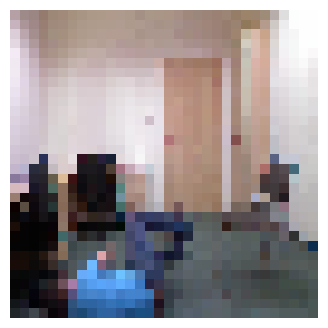

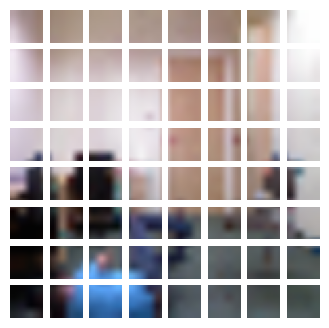

In [89]:
# @title
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")
print(f"Shape of patch: {patches.shape}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = ops.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(ops.convert_to_numpy(patch_img).astype("uint8"))
    plt.axis("off")

In [90]:
class PatchEncoder(layers.Layer):
  def __init__(self, num_patches, projection_dim):
    super().__init__()
    self.num_patches = num_patches

    self.projection = layers.Dense(units=projection_dim)
    self.position_embedding = layers.Embedding(
        input_dim = num_patches, output_dim = projection_dim
    )

  def call(self, patch):
    positions = tf.range(start=0, limit=self.num_patches, delta=1)
    encoded = self.projection(patch) + self.position_embedding(positions)
    return encoded

In [91]:
def vit():
    inputs = keras.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(1, activation='sigmoid')(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model


In [92]:
model = vit()
model.summary()

Model: "functional_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_13            │ (None, 32, 32, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ data_augmentation         │ (None, 128, 128, 3)    │              7 │ input_layer_13[0][0]   │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ patches_13 (Patches)      │ (None, 64, 768)        │              0 │ data_augmentation[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ patch_encoder_8           │ (None, 64, 64)         │         53,312 │ patches_13[0][0]       │
│ (PatchEncoder)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_200   │ (None, 64, 64)         │            128 │ patch_encoder_8[0][0]  │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_96   │ (None, 64, 64)         │         66,368 │ layer_normalization_2… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_192 (Add)             │ (None, 64, 64)         │              0 │ multi_head_attention_… │
│                           │                        │                │ patch_encoder_8[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_201   │ (None, 64, 64)         │            128 │ add_192[0][0]          │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_225 (Dense)         │ (None, 64, 128)        │          8,320 │ layer_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_313 (Dropout)     │ (None, 64, 128)        │              0 │ dense_225[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_226 (Dense)         │ (None, 64, 64)         │          8,256 │ dropout_313[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_314 (Dropout)     │ (None, 64, 64)         │              0 │ dense_226[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_193 (Add)             │ (None, 64, 64)         │              0 │ dropout_314[0][0],     │
│                           │                        │                │ add_192[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_202   │ (None, 64, 64)         │            128 │ add_193[0][0]          │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_97   │ (None, 64, 64)         │         66,368 │ layer_normalization_2… │
│ (MultiHeadAttention) 

 Total params: 11,541,704 (44.03 MB)

 Trainable params: 11,541,697 (44.03 MB)

 Non-trainable params: 7 (32.00 B)

In [93]:
num_epochs = 10
weight_decay = 0.004
learning_rate = 0.001

optimizer = keras.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

# checkpoint_filepath = "/tmp/checkpoint.weights.h5"
# checkpoint_callback = keras.callbacks.ModelCheckpoint(
#     checkpoint_filepath,
#     monitor="val_accuracy",
#     save_best_only=True,
#     save_weights_only=True,
# )

history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=batch_size,
    epochs=num_epochs,
    validation_split=0.2,
)


Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 65s 3s/step - accuracy: 0.5945 - loss: 2.1038 - val_accuracy: 0.1125 - val_loss: 4.2536
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 21s 4s/step - accuracy: 0.6801 - loss: 1.7785 - val_accuracy: 0.6625 - val_loss: 1.1796
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step - accuracy: 0.7155 - loss: 0.9478 - val_accuracy: 0.6500 - val_loss: 1.5332
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - accuracy: 0.7458 - loss: 0.8987 - val_accuracy: 0.6125 - val_loss: 0.8246
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 22s 3s/step - accuracy: 0.7633 - loss: 0.8417 - val_accuracy: 0.8250 - val_loss: 0.3603
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - accuracy: 0.8208 - loss: 0.5492 - val_accuracy: 0.9125 - val_loss: 0.3297
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - accuracy: 0.8352 - loss: 0.4119 - val_accuracy: 0.7625 - val_loss: 0.9804
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 15s 3s/step - accuracy: 0.8243 - loss: 0.5334 - val_accuracy: 0.8625 - val_loss: 0.2951
Epoch 9/

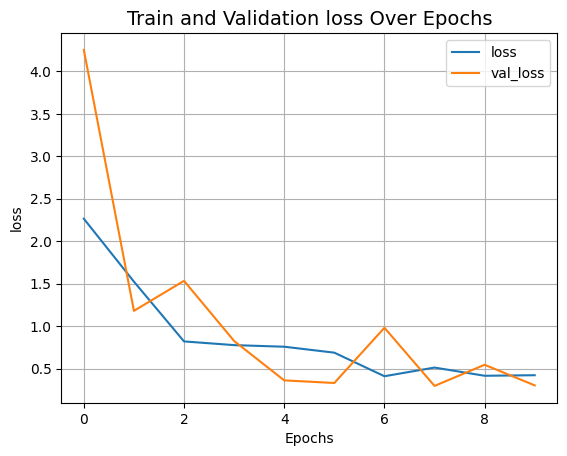

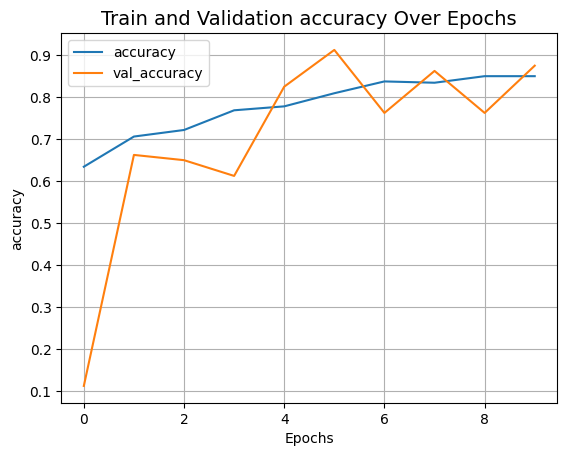

In [94]:
def plot_history(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_history("loss")
plot_history("accuracy")

In [95]:
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)

2/2 - 0s - 233ms/step - accuracy: 0.2500 - loss: 2.4503

Test accuracy: 0.25
